# Individual sensor permutation tests

The heterogeneity figure in the paper is striking. Is it to be trusted, or is there just so much noise in the data that it's unsurprising? Perform per-sensor permutation tests to determine if that distribution is to be trusted.

In [27]:
using KFactors, DataFrames, ThreadsX, Pipe, StatsBase, Random, Plots

In [ ]:
raw_data = KFactors.read_data("../data/peaks_merged.parquet");

In [4]:
data = KFactors.create_test_data(raw_data, KFactors.Periods.SPRING_2022);

In [10]:
data = data[data.period .∈ Ref(Set([:prepandemic, :postlockdown])), :];

In [30]:
sensors = collect(unique(data.station))

per_sensor_test = ThreadsX.map(sensors) do sensor
    permutation_test(data[data.station .== sensor, :], :peak_hour_occ)
end

3514-element Vector{NamedTuple{(:ptest, :pval, :n_sensors), Tuple{Float64, Float64, Int64}}}:
 (ptest = -0.035205472273267785, pval = 0.0, n_sensors = 1)
 (ptest = 0.00039630747192803684, pval = 0.88, n_sensors = 1)
 (ptest = -0.08821816463365792, pval = 0.0, n_sensors = 1)
 (ptest = -0.026889341586163545, pval = 0.0, n_sensors = 1)
 (ptest = -0.017788710690046547, pval = 0.0, n_sensors = 1)
 (ptest = -0.03402223909384422, pval = 0.0, n_sensors = 1)
 (ptest = -0.012147583657533476, pval = 0.002, n_sensors = 1)
 (ptest = -0.009225240222404174, pval = 0.006, n_sensors = 1)
 (ptest = -0.010004061994365931, pval = 0.0, n_sensors = 1)
 (ptest = -0.003605975567194844, pval = 0.21, n_sensors = 1)
 (ptest = -0.0021860631402741, pval = 0.052, n_sensors = 1)
 (ptest = -0.015101586955298452, pval = 0.0, n_sensors = 1)
 (ptest = -0.002025747311471482, pval = 0.472, n_sensors = 1)
 ⋮
 (ptest = -0.007137230106553677, pval = 0.0, n_sensors = 1)
 (ptest = -0.0007652910824448994, pval = 0.922, n_sensor

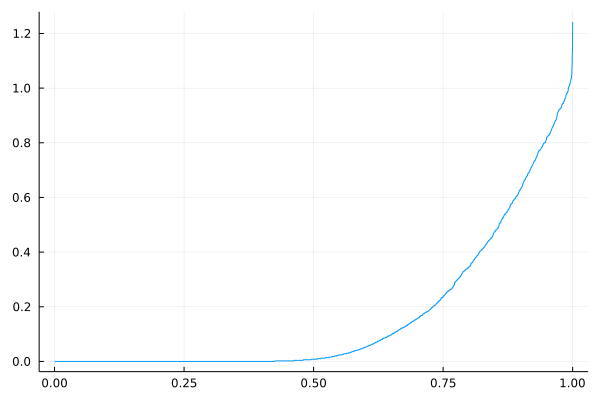

In [36]:
plot((1:length(per_sensor_test)) ./ length(per_sensor_test), sort(map(x -> x.pval, per_sensor_test)), legend=false)

## Conclusion

This p-value distribution shows that there are many significant results. Some p-values are over 1.0 - see [issue 38](https://github.com/mattwigway/peak-spreading/issues/38)

## Empirical estimation of samples

In [24]:
# permutation test is simpler here, since we're doing it per sensor - no need to block bootstrap
# as each per-sensor observation is independent

results = zeros(Float64, 1000, length(sensors))

data.sensor_id = map(id -> findfirst(sensors .== id), data.station)

# barrier function for type stability
function _update(stations, values, results, permutation)
    for (station, value) in zip(stations, values)
        results[permutation, station] = value
    end
end

function sensor_permutations(occ, period)
    permuted_period = Random.shuffle(period)
    mean(@view occ[permuted_period .== :postlockdown]) - mean(@view occ[permuted_period .== :prepandemic])
end

for permutation in collect(1:1000)
    res = @pipe groupby(data, :sensor_id) |>
        combine(_, [:peak_hour_occ, :period] => sensor_permutations => :Δpeak_hour_occ)
    _update(res.sensor_id, res.Δpeak_hour_occ, results, permutation)
end

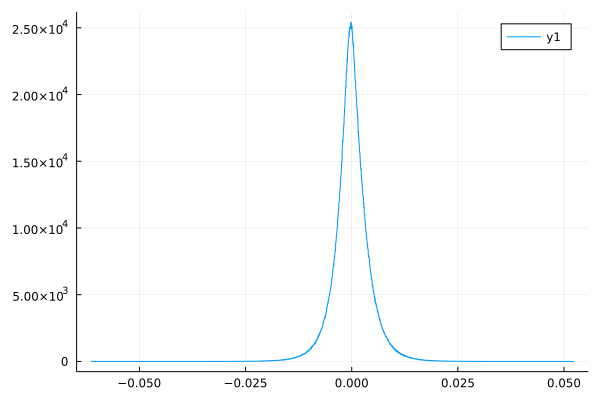

In [28]:
histogram(results[1:end])

## Conclusion

This bootstrapped distribution is much tighter than the observed distribution. Not the (sole) explanation for heterogeneity.